  # Final Project Model Selection & Training
  Name: Lincoln Walker \
  Class Name: MATH-475-01 Statistical Machine Learning \
  Group Names: N/A

## EDA




In [158]:
#Importing needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from astropy import units as u
from astropy.coordinates import Angle


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.datasets import load_iris
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier



from sklearn.impute import SimpleImputer


**In this section I read in my dataset and perform preliminary analysis such as finding the size of the dataset, number of NA values and examining the data types of the columns**

**We discover that the dataset consists of 7351 entries across 87 columns. There are 49 columns that contain NA values, some of which are cloumns that dont contain any values at all.**

In [159]:
#We start by reading in the dataset

#We use comment='#' as a parameter in our read_csv function, as the CSV file from
#NASA contains metadata at the start that will interfere with the reading in of the
#dataset, but since all those rows start with a #, we can tell Python to treat those
#as comments to fix the issue
#tessdf = pd.read_csv('TOI_2024.11.15_08.41.43.csv', comment='#')
tessdf = pd.read_csv('tessdata.csv', comment='#')
#Displaying the first five rows of the columns to get a general idea of the dataset
print("\n======Displaying tessdf.head()======\n")
print(tessdf.head())

#Displaying info about each column so we can know what datatypes we are working with
#and see if there are any categorical values
print("\n======Displaying tessdf.info()======\n")
print(tessdf.info())




#Now we find out how many columns have NA values, and we then
#find out how many NA values there are per column

#First we count how many columns have an NA value in them
print("\n======Number of NA columns======\n")

na_column_count = tessdf.isna().any().sum()

print(na_column_count)

#Next we get the amount of NA values in each column
na_columns = tessdf.isna().sum()
#Then we filter out any columns that dont have NA values,
#so we are left with just the columns with NA's
na_columns = na_columns[na_columns > 0]

#Printing our result so we can see which columns have NA values, and how many NA
#values there are in that column
print("\n======Columns with NA values and their counts======")
print(na_columns)








======Displaying tessdf.head()======

   rowid      toi  toipfx        tid    ctoi_alias  pl_pnum tfopwg_disp  \
0      1  1000.01    1000   50365310  5.036531e+07        1          FP   
1      2  1001.01    1001   88863718  8.886372e+07        1          PC   
2      3  1002.01    1002  124709665  1.247097e+08        1          FP   
3      4  1003.01    1003  106997505  1.069975e+08        1          FP   
4      5  1004.01    1004  238597883  2.385979e+08        1          FP   

          rastr          ra  raerr1  ...  st_loggerr2 st_logglim  \
0  07h29m25.85s  112.357708     NaN  ...        -0.07          0   
1  08h10m19.31s  122.580465     NaN  ...        -0.09          0   
2  06h58m54.47s  104.726966     NaN  ...          NaN          0   
3  07h22m14.39s  110.559945     NaN  ...        -1.64          0   
4  08h08m42.77s  122.178195     NaN  ...        -0.07          0   

   st_loggsymerr   st_rad  st_raderr1  st_raderr2  st_radlim  st_radsymerr  \
0              1  2.169


**Now that we have a general idea about our dataset, we want perform some cleanup on the data so we can do more indepth analysis.  There are some features that we don't need, which are the date the object was added and when it was last updated, so we are going to remove them.**

**Then we want to deal with the categorical values using one-hot encoding will not work, since a few of the categorical values are in sexagesimal format, or base 60, so using one hot encoding would result in hundreds of new columns since each sexagesimal value is unique, so we are going to want to convert these to decimal format.**  

**We then want to handle our NA values.  This will allow us to find the skew of the dataset and see how the features are distributed so we can decide if we need to perform normalization of the data.**


**First we end up removing features we dont want from the dataset,which are the date the stellar object was added to the dataset, and when it was last updated.  These features have no bearing on the classifcation of the stellar object, so removing them will make the dataset a bit easier to use**






In [160]:
#First we remove the features we dont want in our dataset, which are the date the
#stellar object was added to the dataset, and when it was last updated.  These
#features have no bearing on the classifcation of the stellar object, so removing
#them will make the dataset a bit easier to use

tessdf = tessdf.drop(['toi_created', 'rowupdate'], axis=1)

**Next we needed to convert the values in sexagesimal to decimal, whcih was done by creating a function and using the angle function from the Astropy library to do so**

In [161]:


#Function to convert sexagesimal or DMS(degrees minutes seconds) to
#decimal degrees using Astropy
def dms_to_decimal(dms_value):
    angle = Angle(dms_value)
    return angle.degree

#Now we apply our function to the dataset, and convert all columns that are in
#sexagesimal format to decimal

#List of columns to convert and replace
columns_to_convert = ['rastr', 'decstr']

#Replacing the original columns with decimal values
for col in columns_to_convert:
    tessdf[col] = tessdf[col].apply(dms_to_decimal)


**Next we use lable encoding on our target variable, since that will make it easier to deal with, we also check the skew and difference between the min and max values of each feature, and discover that normalization will likely be neccessary**

In [162]:
#Now I will use label encoding on our target variable. It is the only categorical
#variable left, and assigning a value of 1, 2 ,3 ... etc to each class should make
#it easier to model
label_encoder = LabelEncoder()
tessdf['tfopwg_disp'] = label_encoder.fit_transform(tessdf['tfopwg_disp'])





skewness = tessdf.skew()
print("Skewness of features:\n", skewness)


#Now we check the min and max values for the columns in our dataset,
#since that will give an idea of how each feature's scale compares,
#and we need to know so we can decide if we need to normalize the data
print("Feature min and max values:")
print(tessdf.min())
print(tessdf.max())

Skewness of features:
 rowid            0.000000
toi              0.027879
toipfx           0.027878
tid              2.906824
ctoi_alias       2.906824
                  ...    
st_rad          39.895673
st_raderr1      10.681230
st_raderr2     -10.681230
st_radlim        0.000000
st_radsymerr     0.000000
Length: 85, dtype: float64
Feature min and max values:
rowid              1.000000
toi              101.010000
toipfx           101.000000
tid             2876.000000
ctoi_alias      2876.010000
                   ...     
st_rad             0.114827
st_raderr1         0.003357
st_raderr2        -1.723020
st_radlim          0.000000
st_radsymerr       1.000000
Length: 85, dtype: float64
rowid           7.351000e+03
toi             7.169010e+03
toipfx          7.169000e+03
tid             2.041563e+09
ctoi_alias      2.041563e+09
                    ...     
st_rad          1.020300e+02
st_raderr1      1.723020e+00
st_raderr2     -3.357300e-03
st_radlim       0.000000e+00
st_radsymer

**Here we convert our NA values to be the mean for the features that arent missing over 75% of thier values, and remove those that are.  If the feature is highly skewed we use the median instead.  We use the simple_imputer class from sklearn to do this, since it makes the process much easier**

In [163]:


#Dropping columns where more than 75% of the data is missing
threshold = 0.75  #75% missing
tessdf = tessdf.dropna(axis=1, thresh=int((1-threshold) * len(tessdf)))




#Calculating skewness for each numerical column
skewness = tessdf.skew()

#Defining thresholds for skewness
low_skew_threshold = 0.5
high_skew_threshold = -0.5


#SimpleImputer is a class from sklearn that
#allows us to replace missing values with either the mean or median of the column
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')

#use simple_imputer to impute missing values based on skewness
for column in tessdf.select_dtypes(include=['float64', 'int64']).columns:
    #Check skewness of each column
    if skewness[column] < low_skew_threshold and skewness[column] > high_skew_threshold:
        #Low skew: impute with mean
        tessdf[[column]] = mean_imputer.fit_transform(tessdf[[column]])
    else:
        #High skew: impute with median
        tessdf[[column]] = median_imputer.fit_transform(tessdf[[column]])




<ipython-input-163-865bd026d3a2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tessdf[[column]] = mean_imputer.fit_transform(tessdf[[column]])
<ipython-input-163-865bd026d3a2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tessdf[[column]] = mean_imputer.fit_transform(tessdf[[column]])
<ipython-input-163-865bd026d3a2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

**Now we perform some normalization of the data.  Since we want to use an SVM for our model, it is senstive to the scale of the features, and our dataset contains features with larger ranges (e.g., light intensity vs. star temperature) which can dominate the model.**

**We end up using Standardizationm or Z-score Normalization, since it scales the data such that it has a mean of 0 and a standard deviation of 1.  We do this because our features have different scales or units.**

In [164]:
#Excluding the target variable and selecting only the features, here we drop
#rowid and the TESS id columns as well since they arent necessary
X = tessdf.drop(['rowid','toi', 'toipfx','tid', 'tfopwg_disp'], axis=1)

#Creating our scaler object
scaler = StandardScaler()

#Fitting and transforming the data
X_standardized = scaler.fit_transform(X)

#Putting it into a dataframe
X_standardized_df = pd.DataFrame(X_standardized, columns=X.columns)


#Getting our target variable so we can combine it with our new datafram
y = tessdf['tfopwg_disp']

#Combining the normalized features with the target variable
tessdf_normalized = pd.concat([X_standardized_df, y], axis=1)

#
print(tessdf_normalized.head())


   ctoi_alias   pl_pnum     rastr        ra    decstr       dec   st_pmra  \
0   -1.197641 -0.182322 -0.621396 -0.621396 -0.266481 -0.266481 -0.067147   
1   -0.961419 -0.182322 -0.521208 -0.521208 -0.116508 -0.116508 -0.054186   
2   -0.741472 -0.182322 -0.696181 -0.696181 -0.222306 -0.222306 -0.009262   
3   -0.850152 -0.182322 -0.639015 -0.639015 -0.527729 -0.527729 -0.002537   
4   -0.042665 -0.182322 -0.525150 -0.525150 -1.020442 -1.020442 -0.048272   

   st_pmraerr1  st_pmraerr2  st_pmralim  ...  st_loggerr1  st_loggerr2  \
0    -0.222969     0.222969         0.0  ...    -0.267732     0.267732   
1    -0.196025     0.196025         0.0  ...    -0.202132     0.202132   
2    -0.031193     0.031193         0.0  ...    -0.217049     0.217049   
3    -0.292706     0.292706         0.0  ...     4.881908    -4.881908   
4    -0.248328     0.248328         0.0  ...    -0.267732     0.267732   

   st_logglim  st_loggsymerr    st_rad  st_raderr1  st_raderr2  st_radlim  \
0         0.0  

###Summary


**In summary we found that the dataset is farily large, about 86 features with 7351 entries each.  We discovered that about half of the features contained NA values, and a couple were simply empty columns so we filled the missing values with the mean if they had a low skew, and if a high skew we used median, and on the empty columns we simply removed them.  We then found that some of our categorical data was actually in sexagesimal format, so we converted that to decimal, as using encoding on them would result in thousands of different new variables.  For the target variable, since it was the only categorcal value left, we used lable encoding to assign numbers to them, which sould make it easier to use later on.  Lastly we found that the scale of each feature tended to be different so we normalized these features in order to have a consistent scale to work with and ensure our model is as accurate as possible.**

## Model Selection and Training

**Here we split our data into training and test datasets, so it can be used in our model.  We plan to test two different models to compare thier performances, a random forest and an SVM**

In [165]:
#Separate features and target
X = tessdf_normalized.drop(columns=['tfopwg_disp'])  #Drop target column from features
y = tessdf_normalized['tfopwg_disp']  #Target column

#Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**In this section we get the original values for our target variable.  Since we used label encoding on them, they were transformed into numerical values, ie 1 to 5, so we want to see which number corresponds with which of the original values for the type of stellar object.**


**For posterity the values are, 0: 'APC', 1: 'CP', 2: 'FA', 3: 'FP', 4: 'KP', 5: 'PC'**

**They stand for**

**0: Ambugious Planetary Candidate**

**1: Confirmed Planet**

**2: False Alarm**

**3: False Positive**

**4: Known Planet**

**5: Planerary Candidate**



In [166]:


#Getting the original target categories
original_target = tessdf["tfopwg_disp"]

#Getting the mapping, which will show us which values correspond to the type of
#stellar object
mapping = dict(enumerate(label_encoder.classes_))
print("Label Encoding Mapping:", mapping)
class_names = label_encoder.inverse_transform([0, 1, 2, 3, 4, 5])

#Saving the class_names to use to display later
unique_classes = sorted(list(set(y_test)))  #Get unique classes in y_test

print(unique_classes)




Label Encoding Mapping: {0: 'APC', 1: 'CP', 2: 'FA', 3: 'FP', 4: 'KP', 5: 'PC', 6: nan}
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


**First we do a random forest, we choose 200 trees since that seems a resonable  balance between accuracy and perfromance. Max depth is none to ensure that we can find all patterns that may appear in the data.  We set class weight to balanced, as the target variable is somewhat imbalances, there are more planets than the other categories such as fales positives.**


**I choose a random forest as one of the models since The TESS dataset consists of multiple features and a Random Forest is good for capturing non-linear relationships between these features, and the TESS dataset includes imbalanced data ie more planetary candidates, a Random Forest is good for preventing overfitting.**




In [167]:
#Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=200,    #Number of trees in the forest
    max_depth=None,      #Maximum depth of each tree
    random_state=42,
    class_weight="balanced"  #Handle imbalanced classes
)

#Train the model
rf_classifier.fit(X_train, y_train)

#Make predictions
y_pred = rf_classifier.predict(X_test)


**Evaluating our random forest.  We use a confusion matrix and a classification report to see the precission, recall, and f1-scores.**

**Our results are interesting, for precision we find that**

**APC (0.60): 60% of the instances predicted as APC are actually APC.**

**CP (0.84): 84% of the instances predicted as CP are actually CP.**

**FA (0.00): This is problematic, as no instances predicted as FA are actually FA. The model is failing to detect this class.  I looked more into this and the dataset actually does contain FA values, so our model should detect at least a few.**

**FP (0.71): 71% of the instances predicted as FP are actually FP.**

**KP (0.85): 85% of the instances predicted as KP are actually KP.**

**PC (0.69): 69% of the instances predicted as PC are actually PC.**


**For recall we have**

**APC (0.03): Only 3% of the actual APC instances are correctly identified. This is a very low recall, indicating that the model is missing most APC instances.**

**CP (0.17): Only 17% of the actual CP instances are correctly identified. This is also a low recall, suggesting that the model is struggling to detect CP instances.**

**FA (0.00): No actual FA instances are being correctly identified. This is a significant issue, as the model isn't detecting any FA instances at all.**
**FP (0.22): Only 22% of the actual FP instances are correctly identified. The model is missing many FP instances.**

**KP (0.39): 39% of the actual KP instances are correctly identified. The recall is not very high, indicating room for improvement in detecting KP instances.**

**PC (0.99): 99% of the actual PC instances are correctly identified. This is an excellent recall, meaning the model is very good at detecting PC instances.**


**F1-Score gives us**

**APC (0.06): The F1-score is very low for APC, indicating poor performance in terms of both precision and recall.**

**CP (0.28): The F1-score for CP is low, reflecting the low recall and slightly better precision.**

**FA (0.00): The F1-score is also 0 for FA, reflecting the model's inability to detect any instances of FA.**

**FP (0.33): The F1-score for FP is low, indicating some issues with precision and recall.**

**KP (0.53): The F1-score is moderate for KP, showing that the model performs better on this class but still has room for improvement.**

**PC (0.81): The F1-score for PC is quite good, reflecting the high recall and moderate precision for this class.**


**The reason for it failing to detect any False Alarms could be due to insuffeiceent data, as the dataset only contains about 90 false alarms.  I would want to get a larger or improved dataset so we can increase our presicion score for Planetary Candidats, since I feel that is the most important one, as that is what we would want to detect the most if we added our own values to the dataset.  It is interesting that overall the model is most successful at detecting Planetary Candidates, and it makes me wonder that the low scores for Known Plantes, Ambigous Planetary Candidates, and Confirmed Planets, are becuase the model is classifying those as Planetary Candidates instead, since there is likely an overlap between these classes, and as seen by the confusion matrix those classes are often misclassifed as a Planetary Candidate instead.**


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

         APC       0.60      0.03      0.06        99
          CP       0.84      0.17      0.28        95
          FA       0.00      0.00      0.00        17
          FP       0.71      0.22      0.33       207
          KP       0.85      0.39      0.53       121
          PC       0.69      0.99      0.81       932

    accuracy                           0.70      1471
   macro avg       0.62      0.30      0.34      1471
weighted avg       0.70      0.70      0.63      1471



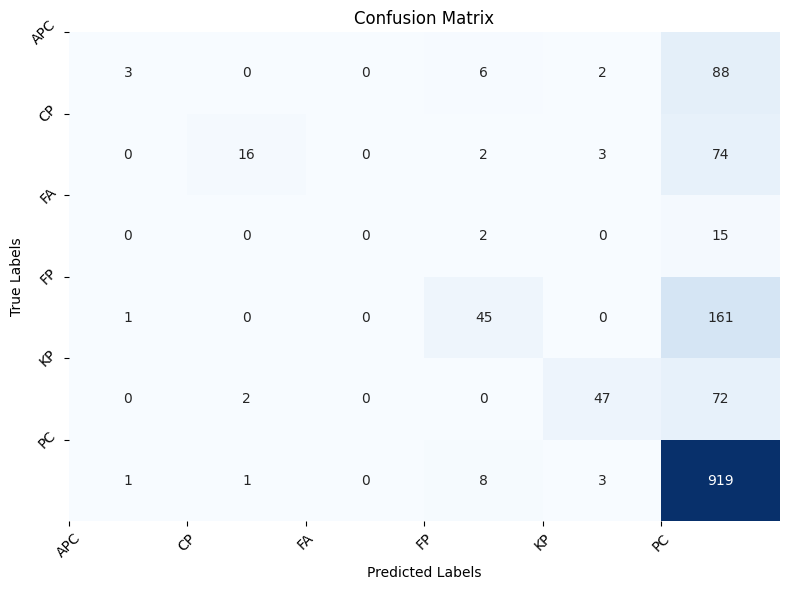

In [168]:



#Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

#Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Adding class names since we use label_encoder so we see the actual names, instead
#of the numbers they were converted to
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

plt.tight_layout()
plt.show()



**Here we print out a bar graph to get an idea of the importance of each feature.**


**We find that the most important feature was pl_tranmid, which is the midpoint of the time the stellar object moves in front of its host star.  The other features are of all similar importance, though only half has much as pl_tranmid.  The least important features were related to the luminosity and temperature of the host star.  I thought those would be a bit more important, since the dimmer the star the harder it would be to detect the objects orbiting it. Pl_tranmid being the most important makes sense though.  Since the time it takes the stellar object to move in front of its host star would be both easier to spot and faster for planets closer to the star, and it would be easier to detect and classify if they are actually planets as well.  Also I'd imagine stuff like asteriod tend to have a far longer pl_tranmid time than a planet, since they tend to have a longer orbit.**

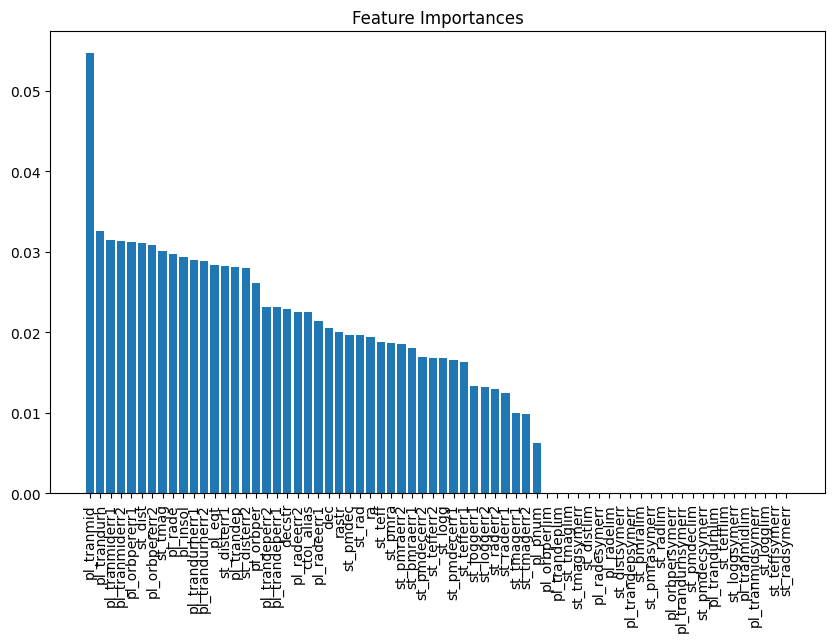

In [169]:
#Feature Importance
feature_importances = rf_classifier.feature_importances_
#Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(feature_importances)), X.columns[sorted_idx], rotation=90)
plt.title("Feature Importances")
plt.show()

**In this section we set up our SVM.**

**We choose an svm as our other model since the TESS dataset has a high number of features, as SVM works well in high-dimensional spaces, and since our dataset includes imbalanced classes, as SVM can handle class imbalance well by adjusting the class_weight parameter.  We set the kernal to use rbfm or Radial Basis Function, since it works well for complex, non-linear relationships between features especially when the relationship between features is not clear or linear.  We set C=1.0, as this balances the risk of overfitting and underfitting.  Using gamma = 'scale' also provides a good balance between underfitting and overfitting.**

In [170]:
# Initialize the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight='balanced')

# Train the model on the training data
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

**In this section we evaluate the model using a classification report and an confusion matrix**


**Our results are interesting, for precision we find that**

**APC (0.25): 25% of the instances predicted as APC are actually APC. This is relatively low, indicating that the model has a high number of false positives for this class.**

**CP (0.27): 27% of the instances predicted as CP are actually CP. Similar to APC, this is not great, indicating that a lot of CP instances are misclassified.**

**FA (0.07): Only 7% of the instances predicted as FA are actually FA. This is very low, suggesting a high number of false positives for this class.**

**FP (0.51): 51% of the instances predicted as FP are actually FP. This is a reasonable precision, but there's still room for improvement.**

**KP (0.33): 33% of the instances predicted as KP are actually KP. This is relatively low, indicating that the model is not very accurate when predicting KP.**

**PC (0.89): 89% of the instances predicted as PC are actually PC. This is very high, indicating that the model is performing well in predicting PC.**

**For recall we have**

**APC (0.58): 58% of the actual APC instances are correctly identified. This is a better recall compared to precision, but there’s still significant room for improvement.**

**CP (0.66): 66% of the actual CP instances are correctly identified. This is decent but still leaves 34% of CP instances undetected.**

**FA (0.24): Only 24% of the actual FA instances are correctly identified. This is quite low, indicating that the model is missing a large portion of the FA instances.**

**FP (0.46): 46% of the actual FP instances are correctly identified. The recall is moderate but needs improvement.**

**KP (0.69): 69% of the actual KP instances are correctly identified. This is a better recall compared to the other classes, but still leaves room for improvement.**

**PC (0.48): 48% of the actual PC instances are correctly identified. While this is decent, the model is missing half of the PC instances, which could be improved.**

**F1-Score gives us**

**APC (0.35): The F1-score is quite low for APC, reflecting the poor precision and moderate recall for this class.**

**CP (0.39): The F1-score for CP is low, indicating a trade-off between precision and recall, but the model’s performance is not optimal for this class.**

**FA (0.11): The F1-score is very low for FA, reflecting the model's inability to detect this class properly.**

**FP (0.48): The F1-score for FP is moderate, showing that the model has some balance between precision and recall, but there's still significant room for improvement.**

**KP (0.45): The F1-score for KP is moderate, showing that the model performs better for this class, but again, it is not excellent.**

**PC (0.63): The F1-score for PC is the highest, indicating a good balance of precision and recall, even though recall could still be improved.**




**In comparsion with our Random Forest, the SVM is more succesfull at detecting False Alarms.  This could be due to how SVM uses a kernal trick technique for transforming the data into higher dimensions, though I am not completly sure and would need to compare perhaps with other models or a larger similar dataset.  It is interesting that  the model is overall worse  at detecting Planetary Candidates, and better at detecting Known Plantes, Ambigous Planetary Candidates, and Confirmed Planets.  It makes me wonder if we are having the same issue but in reverse that we had with the Random Forest, with it mixing up these categories, as examining the confusion matrix we can see that we are misclassfiying Planetary Candidates as Known Plantes, Ambigous Planetary Candidates, and Confirmed Planets a lot more that wiht the Random Forest.**

**To improve this I would want perhaps a larger dataset with this information, or to try other models as well to compare them.  An issue with this dataset is that there are far more Planetary Candidates than the other categories, so one that has a better balance may be more useful.**


Classification Report:
               precision    recall  f1-score   support

         APC       0.25      0.58      0.35        99
          CP       0.27      0.66      0.39        95
          FA       0.07      0.24      0.11        17
          FP       0.51      0.46      0.48       207
          KP       0.33      0.69      0.45       121
          PC       0.89      0.48      0.63       932

   micro avg       0.51      0.51      0.51      1471
   macro avg       0.39      0.52      0.40      1471
weighted avg       0.70      0.51      0.55      1471



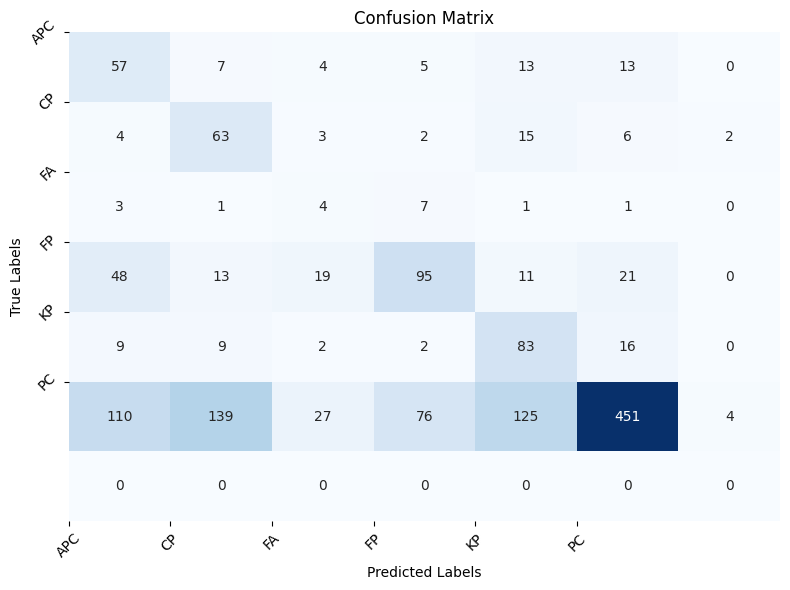

In [171]:
# Make predictions on the test set
y_pred = svm_model.predict(X_test)




#Printing a classification report

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names, labels=unique_classes))





#Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)




#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#Adding class names since we use label_encoder so we see the actual names, instead
#of the numbers they were converted to
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

plt.tight_layout()
plt.show()


### Summary

**In conclusion, we compared two different models for NASA's TESS planeary candidates dataset.  A Random Forest and an SVM.  The performance of the models was not perfect, and could use some improvement.  The models struggle to detect False Alarms, likely due to the insufficient data, though the SVM did a better job at it.  It seems that in both models the overlap between classes, such as Known Planets, Ambiguous Planetary Candidates, and Confirmed Planets, might be contributing to misclassifications, with these classes being misidentified as Planetary Candidates, as indicated by the confusion matrix.**

**For the importance of the features, the midpoint of the time a stellar object moves in front of its host star, was the most important feature.  This makes sense, as the transit time is easier to detect for planets closer to their stars, and planets typically have shorter transit times compared to asteroids. Other features have similar but lesser importance, while luminosity and temperature of the host star were found to be less important than expected.  This suggests that the difficulty in detecting objects orbiting dimmer stars is not as significant in this model's predictions, which is interesting to know.**


**In overall comparision between the two models we tested, the SVM model performed better at detecting False Alarms compared to the Random Forest, potentially due to the kernel trick, which allows SVM to handle high-dimensional data better.  However, the SVM model was worse at detecting Planetary Candidates, and performed better at detecting Known Planets, Ambiguous Planetary Candidates, and Confirmed Planets.  This could indicate that the model is misclassifying Planetary Candidates as these other classes, similar to the issues seen with the Random Forest model, but in reverse, as shown by the two confusion matrices**


**To improve performance, especially for Planetary Candidates, a larger or more balanced dataset is recommended.  The current dataset has a far larger number of Planetary Candidates, which could be skewing the results.  Exploring other models or comparing SVM with different settings may also provide better insights. Balancing the dataset might help the model better distinguish between these categories and improve classification accuracy.  Perhaps the dataset could also benifit from excluding Confirmed and Known Planets, since they have such a large overalap with the Planetary Candidate class.  Future improvemnts would involve me testing this as well, to see if that makes a difference**

